In [4]:
#!/usr/bin/env python
# coding: utf-8

# This script is used to compare ensemble outputs with NLDAS data
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr
import datetime
from tqdm import tqdm

def read_nldas(file_dir, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):

        nldas_file = 'NLDAS_'+str(yr)+'.nc'
        nldas_path = os.path.join(file_dir, nldas_file)

        f_nldas = xr.open_dataset(nldas_path)
        if yr == start_yr:
            pcp = f_nldas['pcp'].values[:] # (time, y, x). unit: mm/day
            time = f_nldas['time'].values[:]
        else:
            pcp = np.concatenate((pcp, f_nldas['pcp'].values[:]), axis = 0)
            time = np.concatenate((time, f_nldas['time'].values[:]), axis = 0)
    return time, pcp

def read_nldas_long(file_dir, nldas_file):

    nldas_path = os.path.join(file_dir, nldas_file)

    f_nldas = xr.open_dataset(nldas_path)
    pcp = f_nldas['pcp'].values[:] # (time, y, x). unit: mm/day
    time = f_nldas['time'].values[:]
    return time, pcp

def read_regress_std(file_dir, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        filename='regress_ts.%d.nc'%(yr)
        file = os.path.join(file_dir, filename)
        f=xr.open_dataset(file)
        time = f['time'].values[:]
        pcp_error = f['pcp_error'].values[:] # std
        tmean_error_2 = f['tmean_error_2'].values[:]
        trange_error_2 = f['trange_error_2'].values[:]
        
        if yr == start_yr:
            time_concat = time
            pcp_error_concat = pcp_error
            tmean_error_2_concat = tmean_error_2
            trange_error_2_concat = trange_error_2
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            pcp_error_concat = np.concatenate((pcp_error_concat, pcp_error), axis=0)
            tmean_error_2_concat = np.concatenate((tmean_error_2_concat, tmean_error_2), axis=0)
            trange_error_2_concat = np.concatenate((trange_error_2_concat, trange_error_2), axis=0)
            
    time_concat = pd.to_datetime(time_concat)        
    return time_concat, pcp_error_concat, tmean_error_2_concat, trange_error_2_concat

def read_regress_std_long(file_dir, filename, varname):

    file = os.path.join(file_dir, filename)
    f=xr.open_dataset(file)
    time = f['time'].values[:]
    error = f[varname].values[:] # std

    time = pd.to_datetime(time)        
    return time, error

def df_DOY(data, time):
    time_month = [t.month for t in time]
    time_day = [t.day for t in time]

    df = pd.DataFrame(data)    
    df['month']=time_month
    df['date']=time_day
    df_DOY = df.groupby(['month','date']).mean()    
    return df_DOY

def DOY_hist(df,bins,perct):
    # calculate grid count/density per error value
    nt = len(df)
    freq_arr = np.zeros((bins,nt))

    # vmin and vmax
    vmin = np.nanmin(df)
    vmax = np.nanpercentile(df,perct) # vmax = np.nanmax(data) 

    pbar = tqdm(total=nt)
    for d in range(nt):
        [hist,bin_edges] = np.histogram(df.iloc[d,:], bins=bins, range=(vmin,vmax),density=True)
        # If density=False, the result will contain the number of samples in each bin.
        # If density=True, the result is the value of the probability density function at the bin, normalized such that the integral over the range is 1.
        freq_arr[:,d] = hist    
        pbar.update(1)
    pbar.close()
    return freq_arr,bin_edges

#======================================================================================================
# main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
nldas_dir = os.path.join(root_dir,'data/nldas_daily_utc_convert')
# nldas_sum_dir = os.path.join(root_dir,'data/nldas_daily_utc_convert_summary_2007_2016')
nldas_sum_dir = os.path.join(root_dir,'data/nldas_daily_utc_convert_summary')

gridinfo_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth.nc')

result_dir = os.path.join(root_dir,'test_uniform_perturb')
test_folders = [d for d in os.listdir(result_dir)]
test_folders = sorted(test_folders)
scenarios_ids = range(0,9) 

time_format = '%Y-%m-%d'
start_yr,end_yr=1979,2019 #2007,2016
plot_date_start = '1979-01-01'#'2007-01-01'
plot_date_end = '2019-12-31'#'2016-12-31'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

bins = 100
dpi_value = 300
output_dir=os.path.join(root_dir, 'scripts/step27_plot_uncertainty_DOY_all')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_filename = 'all_%d_%d.png'%(start_yr,end_yr)
   
# #======================================================================================================
# print('Read gridinfo mask')
# # get xy mask from gridinfo.nc
# f_gridinfo = xr.open_dataset(gridinfo_file)
# mask_xy = f_gridinfo['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.

# #======================================================================================================
# # read historical nldas data
# print('Read nldas data')
# # time,pcp_3d=read_nldas(nldas_dir,start_yr, end_yr)
# time,pcp_3d=read_nldas_long(nldas_sum_dir,'NLDAS_pcp.nc')

# # get time mask from nldas data
# time_obj = pd.to_datetime(time)
# mask_t  = (time_obj >= plot_date_start_obj) & (time_obj <= plot_date_end_obj) 
# time_nldas = time_obj[mask_t]

# nt_nldas = len(time_nldas)
# mask_xy_3d_nldas = np.repeat(mask_xy[np.newaxis,:,:],nt_nldas,axis=0)

# pcp = (pcp_3d[mask_xy_3d_nldas!=0]).reshape((nt_nldas,-1))    

# # calculate DOY (day of year) mean IQR    
# df_nlds = pd.DataFrame(pcp)    
# time_month = [t.month for t in time_nldas]
# time_day = [t.day for t in time_nldas]
# df_nlds['month']=time_month
# df_nlds['date']=time_day  
# df_nlds2 = df_nlds.groupby(['month','date']).mean()

# del pcp_3d,pcp,df_nlds

# #======================================================================================================
# # read scenario ensemble results and save to dictionary
# print('Read regression error')
# k=-2 #-1
# test_folder = test_folders[scenarios_ids[k]]

# print(test_folder)
# test_dir = os.path.join(result_dir, test_folder)
# fig_title= test_folder

# print(' -- read spatial error')
# # read
# nldas_regr_dir = os.path.join(root_dir,'test_uniform_perturb',test_folder,'gmet_regr_summary')
# # time_regr, pcp_error_3d, tmean_error_2_3d, trange_error_2_3d = read_regress_std(nldas_regr_dir, start_yr, end_yr)
# time_regr, pcp_error_3d, = read_regress_std_long(nldas_regr_dir, 'regress_ts_pcp_error.nc', 'pcp_error')
# time_regr, tmean_error_2_3d = read_regress_std_long(nldas_regr_dir, 'regress_ts_tmean_error_2.nc', 'tmean_error_2')
# time_regr, trange_error_2_3d = read_regress_std_long(nldas_regr_dir, 'regress_ts_trange_error_2.nc', 'trange_error_2')

# # define plot mask for nldas regr
# mask_regr_t = (time_regr>=plot_date_start_obj) & (time_regr<=plot_date_end_obj)
# nt_regr = len(mask_regr_t)
# mask_xy_3d_nt_regr = np.repeat(mask_xy[np.newaxis,:,:],nt_regr,axis=0)

# print(' -- reshape')
# # reshpae (nt,ny,nx) -> (nt,ny*nx)
# pcp_error = (pcp_error_3d[mask_xy_3d_nt_regr!=0]).reshape((nt_regr,-1))    
# tmean_error_2 = (tmean_error_2_3d[mask_xy_3d_nt_regr!=0]).reshape((nt_regr,-1))    
# trange_error_2 = (trange_error_2_3d[mask_xy_3d_nt_regr!=0]).reshape((nt_regr,-1))    

# ##======================================================================================================    
# # group regression error for DOY
# print('group by DOY')
# df_pcp = df_DOY(pcp_error, time_regr)
# df_pcp_zero = df_pcp[df_nlds2==0]
# df_pcp_nonzero = df_pcp[df_nlds2!=0]

# df_tmean = df_DOY(tmean_error_2, time_regr)
# df_trange = df_DOY(trange_error_2, time_regr)

# print('histogram for DOY')
# freq_pcp_zero,bin_edges_pcp_zero=DOY_hist(df_pcp_zero,bins,99.5)
# freq_pcp_nonzero,bin_edges_pcp_nonzero=DOY_hist(df_pcp_nonzero,bins,99.5)
# freq_tmean,bin_edges_tmean=DOY_hist(df_tmean,bins,99.5)
# freq_trange,bin_edges_trange=DOY_hist(df_trange,bins,99.5)

# #======================================================================================================    
# # create a white-blue linear colormap
# print('create colormap')

# # reference: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
# cmap = mpl.cm.get_cmap('jet') # get the blue color of jet 
# c0 = cmap(0.0)
# top = mpl.colors.LinearSegmentedColormap.from_list("", ["white",c0])

# # combine two liner colormaps to create a
# # reference: https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
# bottom = mpl.cm.get_cmap('jet')
# newcolors = np.vstack((top(np.linspace(0, 1, int(256*0.2))),bottom(np.linspace(0, 1, int(256*0.8)))))
# newcmp = mpl.colors.LinearSegmentedColormap.from_list("WhiteJet", newcolors)

##======================================================================================================    
# plot
print('Plot')

title_list = ['Precip (when NLDAS-2 PoP = 0)', 'Precip (when NLDAS-2 PoP ≠ 0)', 'Tmean', 'DTR']
ylabel_list = ['Std Dev (mm$\,$day$^{-1}$)', 'Std Dev (mm$\,$day$^{-1}$)', 
               'Std Dev ($^\circ$C)','Std Dev ($^\circ$C)']

# plot each varaiable seperately
nrow = len(title_list) 
ncol = 1           
fig, ax = plt.subplots(nrow, ncol, figsize=(5.5,5.5*100/365.0*4))
color_list = [ newcmp(x) for x in np.linspace(0, 1, bins) ]

for i in range(nrow):
    
    print(title_list[i])

    # calculate precip when nldas=0 and nldas!=0
    if i == 0:
        data = freq_pcp_zero
        bin_edges = bin_edges_pcp_zero
    elif i == 1:
        data = freq_pcp_nonzero
        bin_edges = bin_edges_pcp_nonzero
    elif i == 2:
        data = freq_tmean
        bin_edges = bin_edges_tmean
    elif i == 3:
        data = freq_trange
        bin_edges = bin_edges_trange
   
    # stackplot
    im = ax[i].imshow(data, cmap=newcmp, origin='lower')

    # limit
    ax[i].set_xlim(1,np.shape(data)[1])
#     ax[i].set_ylim(bin_edges[0],bin_edges[-1])

    ax[i].set_yticks(np.linspace(0, ax[i].get_yticks()[-1], 5))
    ylabels = np.linspace(bin_edges[0],bin_edges[-1],5)
    ylabels = [round(yy,1) for yy in ylabels]
    ax[i].set_yticklabels(ylabels)

    # label
    if i == nrow-1:
        xlabel = 'Day of Year (DOY) '
        ax[i].set_xlabel(xlabel, fontsize='xx-small')
    ax[i].set_ylabel(ylabel_list[i], fontsize='xx-small')
    
    # title
    alpha = chr(ord('a') + i)
    ax[i].set_title('('+alpha+') '+title_list[i], fontsize='xx-small', fontweight='semibold', pad=2)

    # tick
    ax[i].tick_params(axis='both', direction='out',labelsize = 'xx-small', 
                        length=2, width=0.5, pad=1.5)

   # change subplot border width
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(0.5)

    # colorbar
    if i == nrow-1:
        fig.subplots_adjust(bottom=0.08, top=1, left = 0, right=1, hspace=0.25)
        cax = fig.add_axes([0.25, 0.001, 0.5, 0.015]) #[left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')

        tick1 = np.nanmax(data)*0.5
        tick2 = np.nanmax(data)
        cbar.set_ticks([0, tick1, tick2]) 
        cbar.set_ticklabels(['Low', 'Medium', 'High'])  
        cbar.ax.tick_params(labelsize='xx-small', length=2, width=1)#, rotation=90)
        cbar.set_label(label='Probability density',size='xx-small')    

# save plot
fig.tight_layout 
fig.savefig(os.path.join(output_dir, output_filename), dpi=dpi_value,
            bbox_inches = 'tight', pad_inches = 0.05)
plt.close(fig)

print('Done')

Plot
Precip (when NLDAS-2 PoP = 0)
Precip (when NLDAS-2 PoP ≠ 0)
Tmean
DTR
Done


### 2. Calculate Pearson correlation between NLDAS precip and estimates ###

In [ ]:
# calculate Pearson correlation between NLDAS precip and estimates
import scipy
from scipy import stats
df_nlds2_nonzero = df_nlds2[df_nlds2!=0]

df_nlds2_mean = np.nanmean(df_nlds2_nonzero,axis=1)
df_pcp_mean = np.nanmean(df_pcp_nonzero,axis=1)

print(scipy.stats.pearsonr(df_nlds2_mean,df_pcp_mean))

(0.7721429168658684, 1.1322589940816914e-73)


### 3. Calculate overall mean standard deviation of all grids and 1979-2019 ###

In [2]:
# calculate overall mean standard deviation of all grids and 1979-2019
print(np.nanmean(df_pcp))
print(np.nanmean(df_tmean))
print(np.nanmean(df_trange))

0.38119325281902755
0.3372103404655208
0.5878341539898558


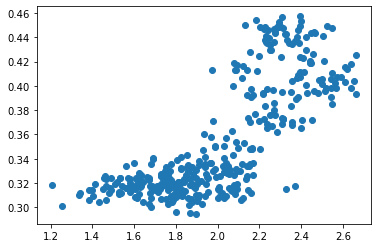

In [12]:
plt.scatter(df_nlds2_mean,df_pcp_mean)

In [7]:
np.shape(df_nlds2_mean)

(80439,)

In [62]:
vmax

3.601881980895996